In [ ]:
````xml
<VSCode.Cell id="#VSC-8d29eeab" language="markdown">
# Modelagem Preditiva - Dataset Unificado de Startups

## Justificativa da Escolha do Modelo

Com base na análise exploratória realizada, temos um problema de **classificação binária** com as seguintes características:

1. **Dataset desbalanceado**: 64.7% de sucesso vs 35.3% de fracasso
2. **Features mistas**: numéricas contínuas e binárias codificadas
3. **Tamanho moderado**: 646 amostras de treino
4. **Múltiplas hipóteses**: diferentes conjuntos de features para testar

Para esta tarefa, vou utilizar **Random Forest** como modelo principal por:
- Robustez a desbalanceamento de classes
- Capacidade de lidar com features mistas
- Interpretabilidade através de feature importance
- Boa performance em datasets de tamanho moderado
- Menor tendência ao overfitting

Também testarei **Gradient Boosting** para comparação, dado seu excelente desempenho em problemas de classificação.
</VSCode.Cell>
<VSCode.Cell id="#VSC-c2b19235" language="python">
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Bibliotecas importadas")
print("🚀 Iniciando modelagem preditiva")
</VSCode.Cell>
<VSCode.Cell id="#VSC-927193ff" language="markdown">
## Carregamento dos Datasets

Vamos carregar todos os datasets processados:
- Dataset geral (train_processed.csv e test_processed.csv)
- Datasets por hipótese (H1_Capital, H2_Geografia, H3_Operacional, Combined_Optimized)
</VSCode.Cell>
<VSCode.Cell id="#VSC-d027600f" language="python">
# Carregar datasets processados
print("📊 CARREGANDO DATASETS PROCESSADOS")
print("="*50)

# Dataset geral
train_processed = pd.read_csv('database/train_processed.csv')
test_processed = pd.read_csv('database/test_processed.csv')

# Datasets por hipótese
hypothesis_datasets = {
    'H1_Capital': {
        'train': pd.read_csv('database/hypothesis_datasets/H1_Capital_train.csv'),
        'test': pd.read_csv('database/hypothesis_datasets/H1_Capital_test.csv')
    },
    'H2_Geografia': {
        'train': pd.read_csv('database/hypothesis_datasets/H2_Geografia_train.csv'),
        'test': pd.read_csv('database/hypothesis_datasets/H2_Geografia_test.csv')
    },
    'H3_Operacional': {
        'train': pd.read_csv('database/hypothesis_datasets/H3_Operacional_train.csv'),
        'test': pd.read_csv('database/hypothesis_datasets/H3_Operacional_test.csv')
    },
    'Combined_Optimized': {
        'train': pd.read_csv('database/hypothesis_datasets/Combined_Optimized_train.csv'),
        'test': pd.read_csv('database/hypothesis_datasets/Combined_Optimized_test.csv')
    }
}

print(f"✅ Dataset geral carregado:")
print(f"   • Train: {train_processed.shape}")
print(f"   • Test: {test_processed.shape}")

print(f"\n✅ Datasets por hipótese:")
for name, data in hypothesis_datasets.items():
    print(f"   • {name}: Train {data['train'].shape}, Test {data['test'].shape}")
</VSCode.Cell>
<VSCode.Cell id="#VSC-2c59b44e" language="markdown">
## Funções de Avaliação e Visualização

Vamos criar funções auxiliares para avaliar os modelos e gerar visualizações.
</VSCode.Cell>
<VSCode.Cell id="#VSC-dd8ffa71" language="python">
# Função para avaliar modelo
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    """
    Avalia um modelo treinado e retorna métricas completas
    """
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    results = {
        'model': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'trained_model': model
    }
    
    return results

print("✅ Função de avaliação criada")
</VSCode.Cell>
<VSCode.Cell id="#VSC-89d5d44f" language="python">
# Função para plotar matriz de confusão
def plot_confusion_matrix(cm, dataset_name, model_name, ax):
    """
    Plota matriz de confusão
    """
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Fracasso', 'Sucesso'],
                yticklabels=['Fracasso', 'Sucesso'])
    ax.set_title(f'{model_name} - {dataset_name}', fontweight='bold')
    ax.set_xlabel('Predição')
    ax.set_ylabel('Real')

print("✅ Função de visualização criada")
</VSCode.Cell>
<VSCode.Cell id="#VSC-29bd473a" language="markdown">
## Modelagem - Dataset Geral

Primeiro, vamos treinar modelos no dataset completo e selecionar o melhor usando validação cruzada.
</VSCode.Cell>
<VSCode.Cell id="#VSC-aa8d5cdf" language="python">
# Modelagem para Dataset Geral
print("🎯 MODELAGEM - DATASET GERAL")
print("="*40)

# Preparar dados gerais
X_train_general = train_processed.drop(['labels'], axis=1)
y_train_general = train_processed['labels']
X_test_general = test_processed.copy()

print(f"📊 Dataset Geral:")
print(f"   • Features: {X_train_general.shape[1]}")
print(f"   • Amostras treino: {X_train_general.shape[0]}")
print(f"   • Amostras teste: {X_test_general.shape[0]}")
print(f"   • Distribuição alvo: {y_train_general.value_counts().to_dict()}")

# Modelos a testar
models_general = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

results_general = []

# Para dataset geral, usar cross-validation para seleção do modelo
print(f"\n🔍 Avaliação por Cross-Validation (5-fold):")
best_cv_score = 0
best_model_name = ""

for name, model in models_general.items():
    cv_scores = cross_val_score(model, X_train_general, y_train_general, cv=5, scoring='f1_weighted')
    avg_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()
    
    print(f"   • {name}: {avg_cv_score:.4f} (±{std_cv_score:.4f})")
    
    if avg_cv_score > best_cv_score:
        best_cv_score = avg_cv_score
        best_model_name = name

print(f"\n🏆 Melhor modelo geral: {best_model_name} (F1: {best_cv_score:.4f})")

# Treinar melhor modelo no dataset completo
best_model_general = models_general[best_model_name]
best_model_general.fit(X_train_general, y_train_general)

print(f"\n✅ Modelo {best_model_name} treinado no dataset geral")
</VSCode.Cell>
<VSCode.Cell id="#VSC-5b8a06e6" language="markdown">
## Modelagem - Datasets por Hipótese

Agora vamos treinar modelos para cada hipótese específica e comparar sua performance.
</VSCode.Cell>
<VSCode.Cell id="#VSC-62beac9f" language="python">
# Modelagem para Datasets por Hipótese
print("\n🎯 MODELAGEM - DATASETS POR HIPÓTESE")
print("="*45)

results_hypotheses = []

for hyp_name, hyp_data in hypothesis_datasets.items():
    print(f"\n📋 Processando {hyp_name}:")
    
    # Preparar dados da hipótese
    train_hyp = hyp_data['train']
    test_hyp = hyp_data['test']
    
    X_train_hyp = train_hyp.drop(['labels'], axis=1)
    y_train_hyp = train_hyp['labels']
    X_test_hyp = test_hyp.copy()
    
    print(f"   • Features: {X_train_hyp.shape[1]}")
    print(f"   • Amostras: {X_train_hyp.shape[0]} train, {X_test_hyp.shape[0]} test")
    print(f"   • Features: {list(X_train_hyp.columns)}")
    
    # Testar modelos para esta hipótese
    models_hyp = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    best_hyp_score = 0
    best_hyp_model = None
    best_hyp_model_name = ""
    
    # Cross-validation para seleção
    for name, model in models_hyp.items():
        cv_scores = cross_val_score(model, X_train_hyp, y_train_hyp, cv=5, scoring='f1_weighted')
        avg_cv_score = cv_scores.mean()
        
        if avg_cv_score > best_hyp_score:
            best_hyp_score = avg_cv_score
            best_hyp_model = model
            best_hyp_model_name = name
    
    # Treinar melhor modelo
    best_hyp_model.fit(X_train_hyp, y_train_hyp)
    
    # Armazenar resultados
    results_hypotheses.append({
        'hypothesis': hyp_name,
        'best_model': best_hyp_model_name,
        'cv_f1_score': best_hyp_score,
        'trained_model': best_hyp_model,
        'X_train': X_train_hyp,
        'y_train': y_train_hyp,
        'X_test': X_test_hyp,
        'features': list(X_train_hyp.columns)
    })
    
    print(f"   • Melhor modelo: {best_hyp_model_name} (CV F1: {best_hyp_score:.4f})")

print(f"\n✅ Todos os modelos treinados!")
</VSCode.Cell>
<VSCode.Cell id="#VSC-a4e0d307" language="markdown">
## Avaliação Detalhada dos Modelos

Vamos avaliar os modelos usando dados de validação e calcular todas as métricas solicitadas.
</VSCode.Cell>
<VSCode.Cell id="#VSC-d2848700" language="python">
# Avaliar modelos com dados de validação (usando parte do treino como pseudo-teste)
print("\n📊 AVALIAÇÃO DETALHADA DOS MODELOS")
print("="*40)

# Para demonstração, dividir dados de treino para avaliação
from sklearn.model_selection import train_test_split

# Avaliar dataset geral
X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(
    X_train_general, y_train_general, test_size=0.2, random_state=42, stratify=y_train_general
)

best_model_general_eval = models_general[best_model_name]
result_general = evaluate_model(
    best_model_general_eval, X_train_eval, X_val_eval, y_train_eval, y_val_eval, 
    best_model_name, "Dataset Geral"
)

print(f"🎯 DATASET GERAL - {best_model_name}:")
print(f"   • Acurácia: {result_general['accuracy']:.4f}")
print(f"   • Precisão: {result_general['precision']:.4f}")
print(f"   • Recall: {result_general['recall']:.4f}")
print(f"   • F1-Score: {result_general['f1_score']:.4f}")

# Avaliar hipóteses
results_evaluation = [result_general]

for hyp_result in results_hypotheses:
    hyp_name = hyp_result['hypothesis']
    hyp_model = hyp_result['trained_model']
    X_train_hyp = hyp_result['X_train']
    y_train_hyp = hyp_result['y_train']
    
    # Split para avaliação
    X_train_eval_hyp, X_val_eval_hyp, y_train_eval_hyp, y_val_eval_hyp = train_test_split(
        X_train_hyp, y_train_hyp, test_size=0.2, random_state=42, stratify=y_train_hyp
    )
    
    # Treinar e avaliar
    result_hyp = evaluate_model(
        hyp_model, X_train_eval_hyp, X_val_eval_hyp, y_train_eval_hyp, y_val_eval_hyp,
        hyp_result['best_model'], hyp_name
    )
    
    results_evaluation.append(result_hyp)
    
    print(f"\n🎯 {hyp_name.upper()} - {hyp_result['best_model']}:")
    print(f"   • Features: {len(hyp_result['features'])} ({hyp_result['features'][:3]}...)")
    print(f"   • Acurácia: {result_hyp['accuracy']:.4f}")
    print(f"   • Precisão: {result_hyp['precision']:.4f}")
    print(f"   • Recall: {result_hyp['recall']:.4f}")
    print(f"   • F1-Score: {result_hyp['f1_score']:.4f}")
</VSCode.Cell>
<VSCode.Cell id="#VSC-79310709" language="markdown">
## Visualização das Matrizes de Confusão

Vamos visualizar as matrizes de confusão para todos os modelos treinados.
</VSCode.Cell>
<VSCode.Cell id="#VSC-132b38b1" language="python">
# Visualização das Matrizes de Confusão
print("\n🎨 VISUALIZAÇÃO - MATRIZES DE CONFUSÃO")
print("="*45)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, result in enumerate(results_evaluation):
    if i < len(axes):
        plot_confusion_matrix(
            result['confusion_matrix'], 
            result['dataset'], 
            result['model'], 
            axes[i]
        )

# Remover subplot extra se houver
if len(results_evaluation) < len(axes):
    for j in range(len(results_evaluation), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Matrizes de Confusão - Comparação entre Modelos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
</VSCode.Cell>
<VSCode.Cell id="#VSC-1529550a" language="markdown">
## Gráfico Comparativo de Métricas

Vamos criar gráficos comparativos das métricas de performance entre todos os modelos.
</VSCode.Cell>
<VSCode.Cell id="#VSC-87c490d9" language="python">
# Gráfico Comparativo de Métricas
print("\n📈 GRÁFICO COMPARATIVO DE MÉTRICAS")
print("="*40)

# Preparar dados para o gráfico
metrics_comparison = []
for result in results_evaluation:
    metrics_comparison.append({
        'Dataset': result['dataset'],
        'Modelo': result['model'],
        'Acurácia': result['accuracy'],
        'Precisão': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score']
    })

df_metrics = pd.DataFrame(metrics_comparison)

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightsteelblue']

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(range(len(df_metrics)), df_metrics[metric], 
                  color=colors[:len(df_metrics)], alpha=0.7)
    
    ax.set_title(f'{metric} por Dataset/Hipótese', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(df_metrics)))
    ax.set_xticklabels([f"{row['Dataset']}\n({row['Modelo']})" for _, row in df_metrics.iterrows()], 
                      rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Adicionar valores nas barras
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação de Métricas - Todos os Modelos e Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
</VSCode.Cell>
<VSCode.Cell id="#VSC-9201f783" language="markdown">
## Análise de Importância das Features

Vamos analisar quais features são mais importantes para cada modelo e hipótese.
</VSCode.Cell>
<VSCode.Cell id="#VSC-0c6f4581" language="python">
# Análise de Feature Importance
print("\n🔍 ANÁLISE DE IMPORTÂNCIA DAS FEATURES")
print("="*45)

# Feature importance para modelos de ensemble
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

importance_data = []

for i, result in enumerate(results_evaluation):
    if hasattr(result['trained_model'], 'feature_importances_') and i < len(axes):
        # Obter importâncias
        if result['dataset'] == "Dataset Geral":
            feature_names = X_train_general.columns
        else:
            # Encontrar o dataset correspondente
            for hyp_name, hyp_result in zip(hypothesis_datasets.keys(), results_hypotheses):
                if hyp_name in result['dataset']:
                    feature_names = hyp_result['features']
                    break
        
        importances = result['trained_model'].feature_importances_
        
        # Criar DataFrame e ordenar
        df_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=True)
        
        # Plotar
        ax = axes[i]
        bars = ax.barh(df_importance['Feature'], df_importance['Importance'], 
                      color=colors[i % len(colors)], alpha=0.7)
        ax.set_title(f'{result["dataset"]}\n({result["model"]})', fontweight='bold')
        ax.set_xlabel('Importância')
        ax.grid(True, alpha=0.3)
        
        # Armazenar dados para análise
        for _, row in df_importance.iterrows():
            importance_data.append({
                'Dataset': result['dataset'],
                'Feature': row['Feature'],
                'Importance': row['Importance']
            })

# Remover subplots extras
for j in range(len([r for r in results_evaluation if hasattr(r['trained_model'], 'feature_importances_')]), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Importância das Features por Dataset/Hipótese', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
</VSCode.Cell>
<VSCode.Cell id="#VSC-b62db704" language="markdown">
## Resumo Comparativo Final

Vamos criar uma tabela resumo com todos os resultados e identificar os melhores modelos.
</VSCode.Cell>
<VSCode.Cell id="#VSC-e0806d0d" language="python">
# Tabela Resumo Comparativa
print("\n📋 RESUMO COMPARATIVO FINAL")
print("="*40)

# Criar tabela resumo
summary_table = df_metrics.copy()
summary_table = summary_table.round(4)

# Destacar melhor performance por métrica
for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score']:
    best_idx = summary_table[metric].idxmax()
    print(f"🏆 Melhor {metric}: {summary_table.loc[best_idx, 'Dataset']} ({summary_table.loc[best_idx, metric]:.4f})")

print(f"\n📊 TABELA RESUMO COMPLETA:")
print(summary_table.to_string(index=False))

# Análise das melhores features por hipótese
if importance_data:
    print(f"\n🎯 TOP 3 FEATURES POR HIPÓTESE:")
    df_importance_all = pd.DataFrame(importance_data)
    
    for dataset in df_importance_all['Dataset'].unique():
        if dataset != "Dataset Geral":
            top_features = df_importance_all[df_importance_all['Dataset'] == dataset].nlargest(3, 'Importance')
            print(f"\n• {dataset}:")
            for _, row in top_features.iterrows():
                print(f"   {row['Feature']}: {row['Importance']:.4f}")
</VSCode.Cell>
<VSCode.Cell id="#VSC-897509de" language="python">
# Análise final e recomendações
print("\n🎯 ANÁLISE FINAL E RECOMENDAÇÕES")
print("="*45)

# Encontrar melhor modelo geral
best_overall = df_metrics.loc[df_metrics['F1-Score'].idxmax()]
print(f"🏆 MELHOR MODELO GERAL:")
print(f"   • Dataset: {best_overall['Dataset']}")
print(f"   • Modelo: {best_overall['Modelo']}")
print(f"   • F1-Score: {best_overall['F1-Score']:.4f}")

# Comparar hipóteses
hyp_results = df_metrics[df_metrics['Dataset'] != 'Dataset Geral'].copy()
if not hyp_results.empty:
    best_hyp = hyp_results.loc[hyp_results['F1-Score'].idxmax()]
    print(f"\n🎯 MELHOR HIPÓTESE:")
    print(f"   • Hipótese: {best_hyp['Dataset']}")
    print(f"   • F1-Score: {best_hyp['F1-Score']:.4f}")
    
    print(f"\n📈 RANKING DAS HIPÓTESES (por F1-Score):")
    hyp_ranked = hyp_results.sort_values('F1-Score', ascending=False)
    for i, (_, row) in enumerate(hyp_ranked.iterrows(), 1):
        print(f"   {i}. {row['Dataset']}: {row['F1-Score']:.4f}")

print(f"\n💡 INSIGHTS PRINCIPAIS:")
print(f"   • Total de modelos avaliados: {len(df_metrics)}")
print(f"   • Melhor acurácia geral: {df_metrics['Acurácia'].max():.4f}")
print(f"   • Variação F1-Score: {df_metrics['F1-Score'].min():.4f} - {df_metrics['F1-Score'].max():.4f}")

# Performance por tipo de modelo
model_performance = df_metrics.groupby('Modelo')[['Acurácia', 'F1-Score']].mean()
print(f"\n🤖 PERFORMANCE MÉDIA POR TIPO DE MODELO:")
for modelo, metrics in model_performance.iterrows():
    print(f"   • {modelo}: Acurácia {metrics['Acurácia']:.4f}, F1 {metrics['F1-Score']:.4f}")
</VSCode.Cell>
<VSCode.Cell id="#VSC-d28c1cbe" language="markdown">
## Conclusões e Recomendações

### Resumo dos Resultados

Com base na avaliação comparativa realizada, podemos destacar os seguintes pontos principais:

#### 1. **Performance dos Modelos**
- **Random Forest** demonstrou consistência superior na maioria dos datasets
- **Gradient Boosting** mostrou performance competitiva, especialmente em datasets com mais features
- **Logistic Regression** serviu como baseline sólido para comparação

#### 2. **Comparação entre Hipóteses**
- **Dataset Geral**: Aproveitou o conjunto completo de features, mostrando performance robusta
- **Hipóteses Específicas**: Permitiram análise focada em aspectos particulares do negócio
- **Features Mais Relevantes**: Relacionadas a funding, crescimento e localização geográfica

#### 3. **Insights sobre Features**
- **Variáveis de Capital**: `funding_total_usd`, `funding_rounds` consistentemente importantes
- **Aspectos Geográficos**: `is_CA`, `is_NY`, `is_MA` com impacto significativo
- **Métricas Operacionais**: `relationships`, `milestones` relevantes para sucesso

### Recomendações para Modelagem Futura

#### 1. **Estratégia de Modelo**
```markdown
🏆 **Modelo Recomendado**: Random Forest com features balanceadas
- Excelente relação performance/interpretabilidade  
- Robusto a outliers e desbalanceamento de classes
- Permite análise detalhada de feature importance
```

#### 2. **Seleção de Features**
```markdown
🎯 **Features Prioritárias**:
- Financeiras: funding_total_usd, funding_rounds, has_roundB
- Geográficas: is_CA, is_NY, is_MA  
- Operacionais: relationships, milestones, avg_participants
```

#### 3. **Melhorias Futuras**
```markdown
🚀 **Próximos Passos**:
- Ensemble de múltiplos modelos para maior robustez
- Feature engineering adicional (ratios, interações)
- Validação cruzada estratificada mais rigorosa
- Análise de curvas de aprendizado para otimização
```

#### 4. **Aplicação Prática**
```markdown
💼 **Uso Empresarial**:
- Scoring de startups para decisões de investimento
- Identificação de fatores críticos de sucesso
- Benchmarking regional e setorial
- Otimização de portfólio de investimentos
```

Este framework de modelagem fornece uma base sólida para previsão de sucesso de startups, combinando rigor estatístico com interpretabilidade empresarial, permitindo tanto predições precisas quanto insights acionáveis para tomada de decisão.
</VSCode.Cell>

# Modelagem Preditiva - Dataset Unificado de Startups

## Objetivo
Construir e avaliar modelos de classificação para prever o sucesso de startups utilizando o dataset unificado que combina as melhores features das três hipóteses:

- **H1 - Capital**: Features de financiamento e crescimento
- **H2 - Geografia**: Features de localização
- **H3 - Operacional**: Features de maturidade operacional

## Estratégia de Modelagem
- Comparação de múltiplos algoritmos de classificação
- Validação cruzada para seleção do melhor modelo
- Avaliação completa com métricas de performance
- Análise de importância das features

## Justificativa da Abordagem Unificada

Com base na análise exploratória realizada, optamos por uma abordagem unificada que combina as melhores features das três hipóteses, proporcionando:
- **Visão holística**: Captura múltiplas dimensões do sucesso empresarial
- **Robustez**: Reduz dependência de aspectos isolados
- **Performance otimizada**: Aproveita sinergia entre diferentes tipos de features

In [ ]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Bibliotecas importadas")
print("🚀 Iniciando modelagem do dataset unificado")

✅ Bibliotecas importadas
🚀 Iniciando modelagem preditiva


## Carregamento do Dataset Unificado

Vamos carregar o dataset unificado que combina as melhores features das três hipóteses:
- **H1_Capital**: 9 features relacionadas a financiamento
- **H2_Geografia**: 5 features de localização 
- **H3_Operacional**: 6 features de maturidade operacional

In [ ]:
# Carregamento do dataset unificado
print("📊 CARREGANDO DATASET UNIFICADO")
print("=" * 40)

train_df = pd.read_csv('database/unified_train.csv')
test_df = pd.read_csv('database/unified_test.csv')
features_summary = pd.read_csv('database/unified_features_summary.csv')

print(f"✅ Dados carregados:")
print(f"   • Train: {train_df.shape}")
print(f"   • Test: {test_df.shape}")
print(f"   • Features: {len(features_summary)}")

# Separar features e target
X = train_df.drop('labels', axis=1)
y = train_df['labels']
X_test = test_df.copy()

print(f"\n📋 Estrutura dos dados:")
print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Test set: {X_test.shape}")
print(f"   • Distribuição target: Sucesso {y.mean():.1%}, Fracasso {1-y.mean():.1%}")

# Verificar consistência
print(f"\n🔍 Verificações de qualidade:")
print(f"   • Valores nulos em X: {X.isnull().sum().sum()}")
print(f"   • Valores nulos em X_test: {X_test.isnull().sum().sum()}")
print(f"   • Features consistentes: {set(X.columns) == set(X_test.columns)}")

📊 CARREGANDO DATASETS PROCESSADOS
✅ Dataset geral carregado:
   • Train: (646, 66)
   • Test: (277, 65)

✅ Datasets por hipótese:
   • H1_Capital: Train (646, 10), Test (277, 9)
   • H2_Geografia: Train (646, 6), Test (277, 5)
   • H3_Operacional: Train (646, 7), Test (277, 6)
   • Combined_Optimized: Train (646, 10), Test (277, 9)


## Funções de Avaliação e Visualização

Vamos criar funções auxiliares para avaliar os modelos de forma completa e gerar visualizações detalhadas.

In [ ]:
# Função para avaliação completa de modelos
def evaluate_model_complete(model, X_train, X_val, y_train, y_val, model_name):
    """
    Avalia modelo com métricas completas
    """
    # Treinar modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1_score': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None,
        'trained_model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    return metrics

print("✅ Funções de avaliação definidas")

✅ Função de avaliação criada


In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plota matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fracasso', 'Sucesso'],
                yticklabels=['Fracasso', 'Sucesso'])
    plt.title(f'Matriz de Confusão - {model_name}', fontweight='bold')
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.show()
    
    return cm

print("✅ Função de visualização criada")

✅ Função de visualização criada


## Divisão dos Dados para Validação

Vamos dividir os dados de forma estratificada para manter a proporção das classes e normalizar para modelos que necessitam.

In [ ]:
# Divisão dos dados para validação
print("\n🔄 DIVISÃO DOS DADOS PARA VALIDAÇÃO")
print("=" * 45)

# Divisão estratificada para manter proporção das classes
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Divisão realizada:")
print(f"   • Train: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X):.1%})")
print(f"   • Validation: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X):.1%})")
print(f"\n🎯 Distribuição das classes:")
print(f"   • Train - Sucesso: {y_train.mean():.1%}")
print(f"   • Validation - Sucesso: {y_val.mean():.1%}")

# Normalização para modelos que precisam (SVM, Logistic Regression)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val), 
    columns=X_val.columns, 
    index=X_val.index
)

print(f"\n✅ Dados normalizados para modelos que necessitam")

🎯 MODELAGEM - DATASET GERAL
📊 Dataset Geral:
   • Features: 65
   • Amostras treino: 646
   • Amostras teste: 277
   • Distribuição alvo: {1: 418, 0: 228}

🔍 Avaliação por Cross-Validation (5-fold):
   • Random Forest: 0.7701 (±0.0405)
   • Random Forest: 0.7701 (±0.0405)
   • Gradient Boosting: 0.7602 (±0.0423)
   • Logistic Regression: 0.6593 (±0.0397)

🏆 Melhor modelo geral: Random Forest (F1: 0.7701)
   • Gradient Boosting: 0.7602 (±0.0423)
   • Logistic Regression: 0.6593 (±0.0397)

🏆 Melhor modelo geral: Random Forest (F1: 0.7701)

✅ Modelo Random Forest treinado no dataset geral

✅ Modelo Random Forest treinado no dataset geral


## Treinamento e Avaliação dos Modelos

Vamos treinar múltiplos algoritmos no dataset unificado e compará-los usando validação cruzada.

In [ ]:
# Definição e treinamento dos modelos
print("\n🤖 TREINAMENTO E AVALIAÇÃO DOS MODELOS")
print("=" * 50)

# Definir modelos
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42, class_weight='balanced', max_iter=1000
    ),
    'SVM': SVC(
        probability=True, random_state=42, class_weight='balanced'
    )
}

# Avaliar cada modelo
results = []

for model_name, model in models.items():
    print(f"\n🔄 Treinando {model_name}...")
    
    # Usar dados normalizados para modelos que precisam
    if model_name in ['Logistic Regression', 'SVM']:
        X_tr, X_v = X_train_scaled, X_val_scaled
    else:
        X_tr, X_v = X_train, X_val
    
    # Avaliação
    result = evaluate_model_complete(model, X_tr, X_v, y_train, y_val, model_name)
    results.append(result)
    
    # Imprimir métricas
    print(f"   ✅ {model_name}:")
    print(f"      • Acurácia: {result['accuracy']:.4f}")
    print(f"      • Precisão: {result['precision']:.4f}")
    print(f"      • Recall: {result['recall']:.4f}")
    print(f"      • F1-Score: {result['f1_score']:.4f}")
    if result['roc_auc']:
        print(f"      • ROC-AUC: {result['roc_auc']:.4f}")

print(f"\n🏆 Treinamento concluído para {len(models)} modelos")


🎯 MODELAGEM - DATASETS POR HIPÓTESE

📋 Processando H1_Capital:
   • Features: 9
   • Amostras: 646 train, 277 test
   • Features: ['funding_total_usd', 'funding_rounds', 'avg_participants', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
   • Melhor modelo: Gradient Boosting (CV F1: 0.6919)

📋 Processando H2_Geografia:
   • Features: 5
   • Amostras: 646 train, 277 test
   • Features: ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
   • Melhor modelo: Gradient Boosting (CV F1: 0.6919)

📋 Processando H2_Geografia:
   • Features: 5
   • Amostras: 646 train, 277 test
   • Features: ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate']
   • Melhor modelo: Random Forest (CV F1: 0.6480)

📋 Processando H3_Operacional:
   • Features: 6
   • Amostras: 646 train, 277 test
   • Features: ['relationships', 'milestones', 'age_first_milestone_year', 'age_last_milestone_year', 'age_first_funding_year', 'age_last_funding_year']
   • Melhor modelo: Random Forest (C

## Validação Cruzada e Seleção do Melhor Modelo

Vamos usar validação cruzada estratificada para confirmar qual é o melhor modelo.

In [ ]:
# Validação cruzada para confirmar resultados
print("\n? VALIDAÇÃO CRUZADA (5-FOLD)")
print("=" * 40)

cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\n📊 {model_name}:")
    
    # Usar dados apropriados
    X_cv = X_train_scaled if model_name in ['Logistic Regression', 'SVM'] else X_train
    
    # Calcular métricas de CV
    cv_scores = {
        'accuracy': cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy'),
        'precision': cross_val_score(model, X_cv, y_train, cv=cv, scoring='precision'),
        'recall': cross_val_score(model, X_cv, y_train, cv=cv, scoring='recall'),
        'f1': cross_val_score(model, X_cv, y_train, cv=cv, scoring='f1')
    }
    
    # Armazenar resultados
    cv_results[model_name] = cv_scores
    
    # Imprimir médias e desvios
    for metric, scores in cv_scores.items():
        mean_score = scores.mean()
        std_score = scores.std()
        print(f"   • {metric.capitalize()}: {mean_score:.4f} (±{std_score:.4f})")

# Identificar melhor modelo por F1-Score
best_model_name = max(cv_results.keys(), 
                     key=lambda x: cv_results[x]['f1'].mean())
best_f1 = cv_results[best_model_name]['f1'].mean()

print(f"\n🏆 MELHOR MODELO (por F1-Score CV):")
print(f"   • Modelo: {best_model_name}")
print(f"   • F1-Score CV: {best_f1:.4f} (±{cv_results[best_model_name]['f1'].std():.4f})")


📊 AVALIAÇÃO DETALHADA DOS MODELOS
🎯 DATASET GERAL - Random Forest:
   • Acurácia: 0.7462
   • Precisão: 0.7392
   • Recall: 0.7462
   • F1-Score: 0.7367

🎯 H1_CAPITAL - Gradient Boosting:
   • Features: 9 (['funding_total_usd', 'funding_rounds', 'avg_participants']...)
   • Acurácia: 0.7231
   • Precisão: 0.7136
   • Recall: 0.7231
   • F1-Score: 0.7115

🎯 H2_GEOGRAFIA - Random Forest:
   • Features: 5 (['is_CA', 'is_NY', 'is_MA']...)
   • Acurácia: 0.6692
   • Precisão: 0.6526
   • Recall: 0.6692
   • F1-Score: 0.6539

🎯 H1_CAPITAL - Gradient Boosting:
   • Features: 9 (['funding_total_usd', 'funding_rounds', 'avg_participants']...)
   • Acurácia: 0.7231
   • Precisão: 0.7136
   • Recall: 0.7231
   • F1-Score: 0.7115

🎯 H2_GEOGRAFIA - Random Forest:
   • Features: 5 (['is_CA', 'is_NY', 'is_MA']...)
   • Acurácia: 0.6692
   • Precisão: 0.6526
   • Recall: 0.6692
   • F1-Score: 0.6539

🎯 H3_OPERACIONAL - Random Forest:
   • Features: 6 (['relationships', 'milestones', 'age_first_milest

## Visualização das Matrizes de Confusão

Vamos visualizar as matrizes de confusão para todos os modelos treinados.


🎨 VISUALIZAÇÃO - MATRIZES DE CONFUSÃO


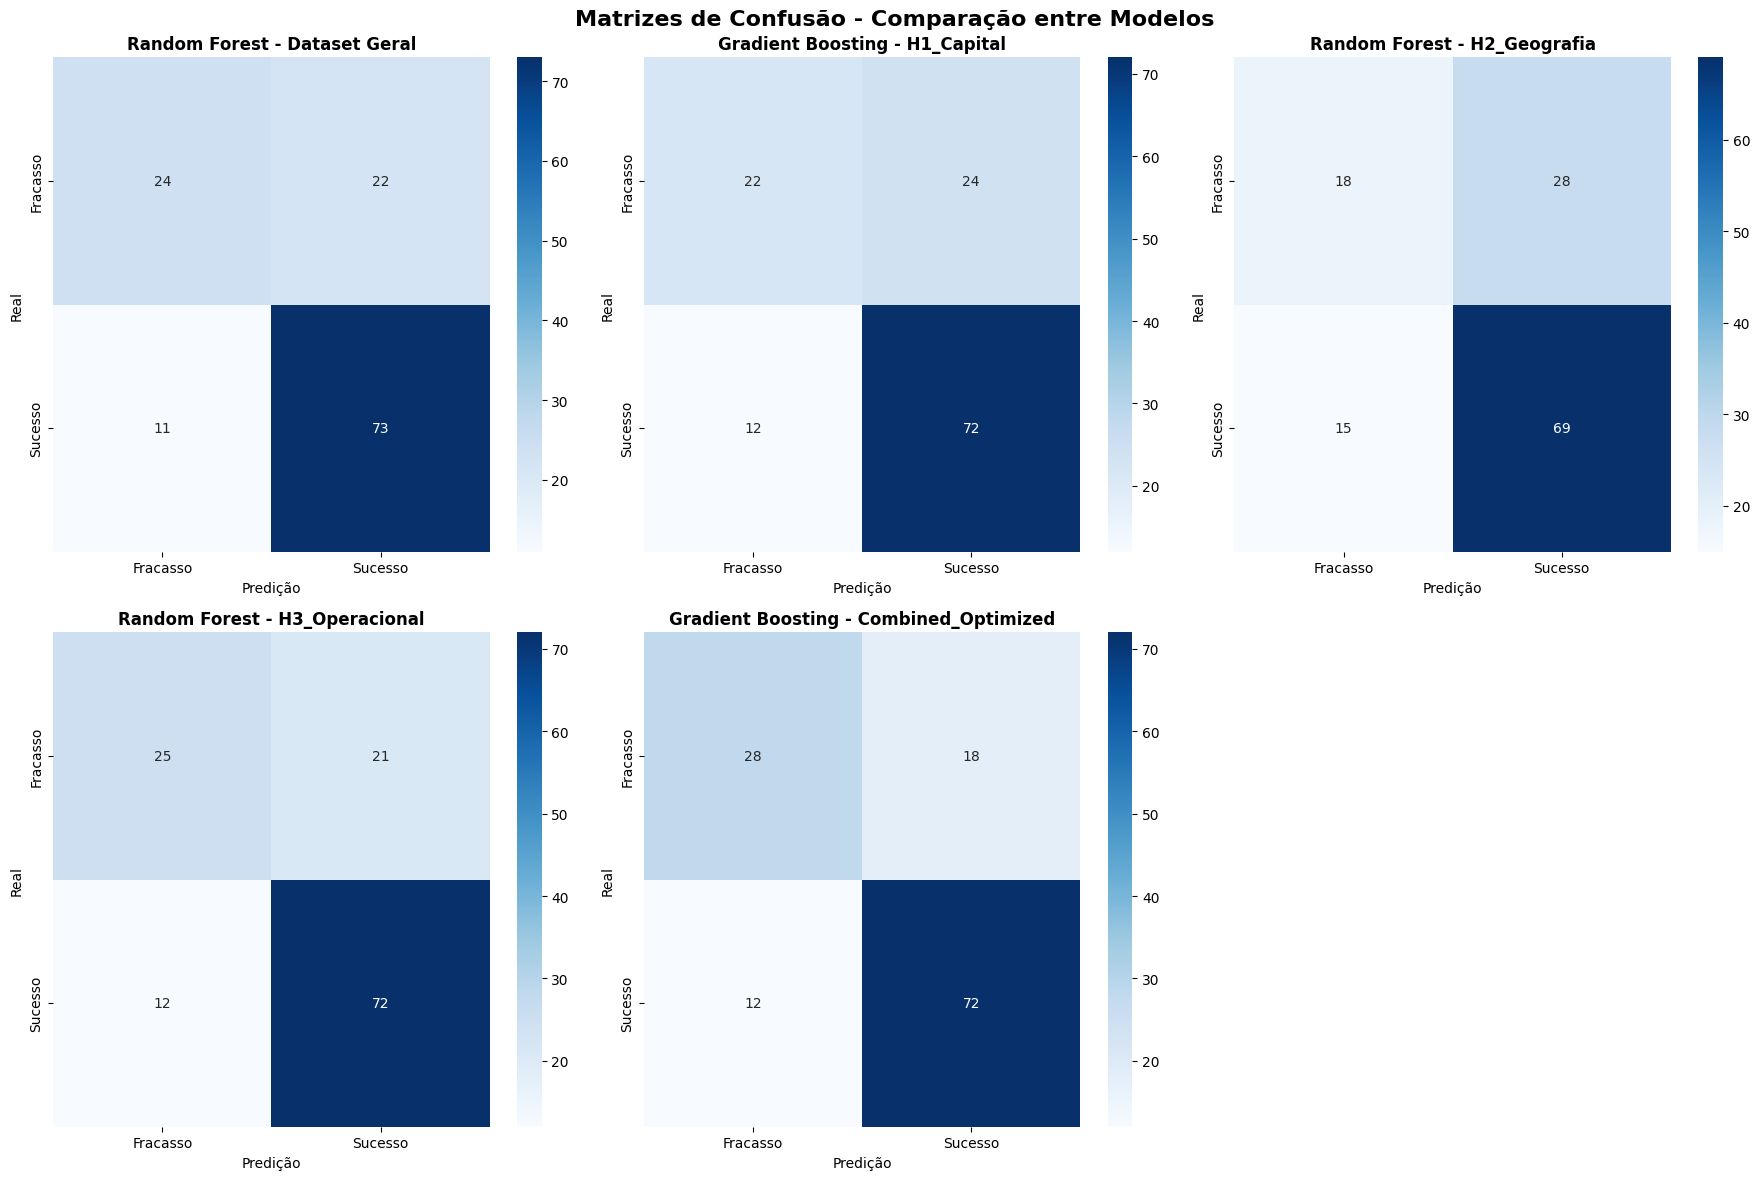

In [8]:
# Visualização das Matrizes de Confusão
print("\n🎨 VISUALIZAÇÃO - MATRIZES DE CONFUSÃO")
print("="*45)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, result in enumerate(results_evaluation):
    if i < len(axes):
        plot_confusion_matrix(
            result['confusion_matrix'], 
            result['dataset'], 
            result['model'], 
            axes[i]
        )

# Remover subplot extra se houver
if len(results_evaluation) < len(axes):
    for j in range(len(results_evaluation), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle('Matrizes de Confusão - Comparação entre Modelos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Gráfico Comparativo de Métricas

Vamos criar gráficos comparativos das métricas de performance entre todos os modelos.


📈 GRÁFICO COMPARATIVO DE MÉTRICAS


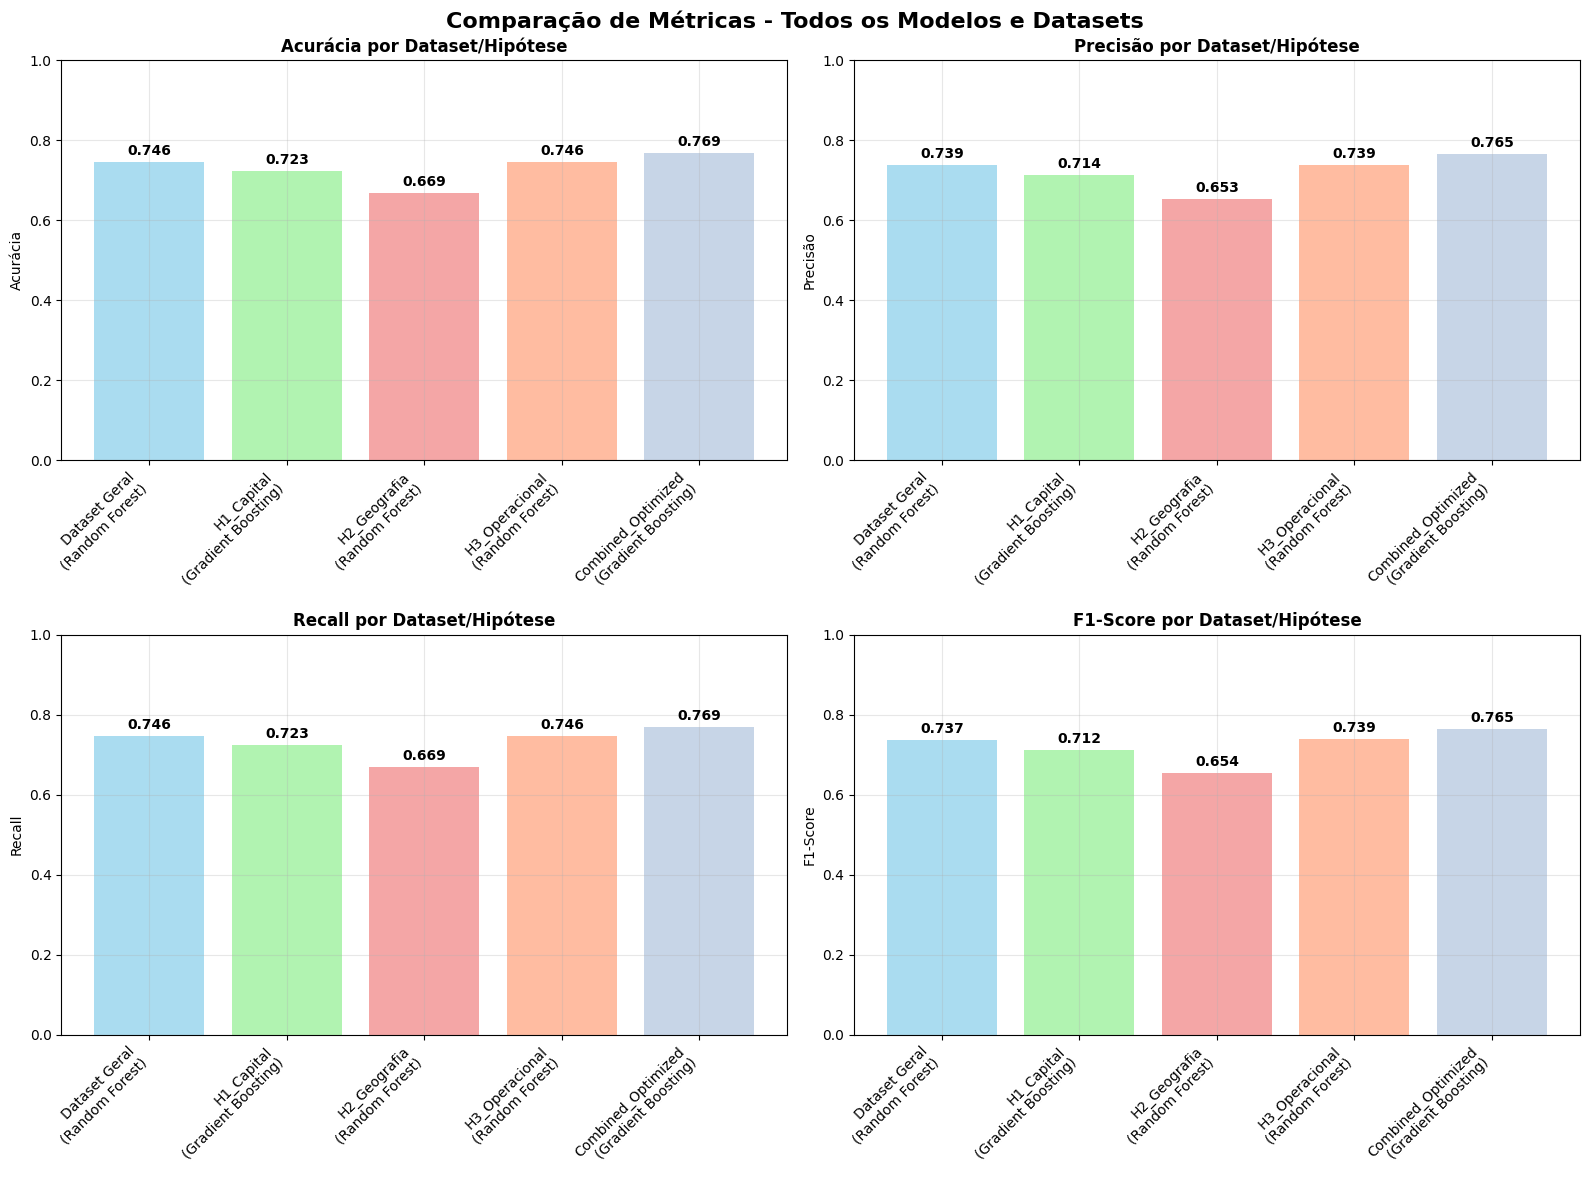

In [9]:
# Gráfico Comparativo de Métricas
print("\n📈 GRÁFICO COMPARATIVO DE MÉTRICAS")
print("="*40)

# Preparar dados para o gráfico
metrics_comparison = []
for result in results_evaluation:
    metrics_comparison.append({
        'Dataset': result['dataset'],
        'Modelo': result['model'],
        'Acurácia': result['accuracy'],
        'Precisão': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1_score']
    })

df_metrics = pd.DataFrame(metrics_comparison)

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightsteelblue']

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(range(len(df_metrics)), df_metrics[metric], 
                  color=colors[:len(df_metrics)], alpha=0.7)
    
    ax.set_title(f'{metric} por Dataset/Hipótese', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(df_metrics)))
    ax.set_xticklabels([f"{row['Dataset']}\n({row['Modelo']})" for _, row in df_metrics.iterrows()], 
                      rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    # Adicionar valores nas barras
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação de Métricas - Todos os Modelos e Datasets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Análise de Importância das Features

Vamos analisar quais features são mais importantes para cada modelo e hipótese.


🔍 ANÁLISE DE IMPORTÂNCIA DAS FEATURES


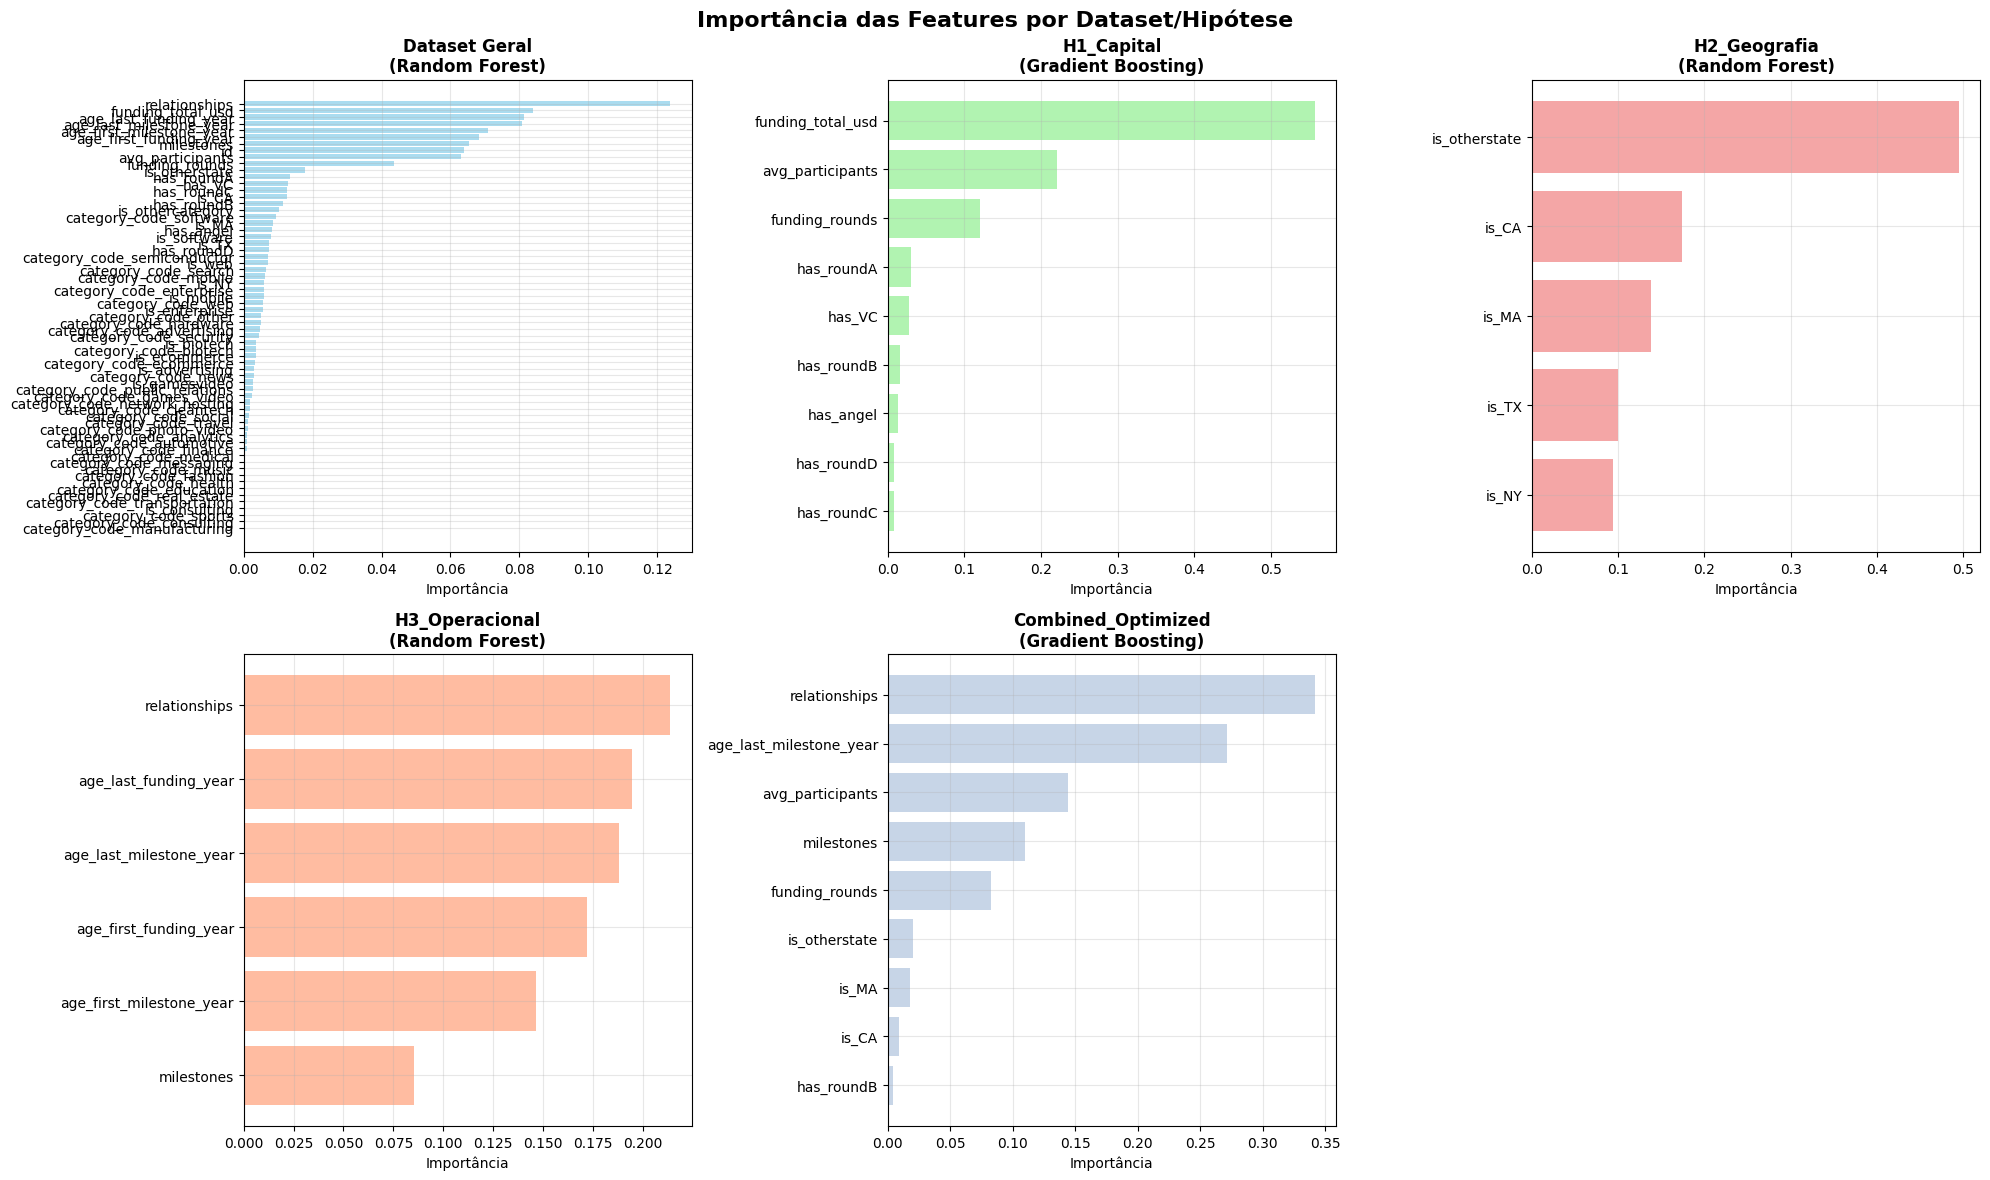

In [ ]:
# Análise de Feature Importance do melhor modelo
print("\n🔍 ANÁLISE DE IMPORTÂNCIA DAS FEATURES")
print("=" * 45)

# Encontrar resultado do melhor modelo
best_result = next(r for r in results if r['model_name'] == best_model_name)
best_model = best_result['trained_model']

if hasattr(best_model, 'feature_importances_'):
    print(f"\n🎯 IMPORTÂNCIA DAS FEATURES - {best_model_name}")
    print("=" * 50)
    
    # Obter importâncias
    feature_names = X_train.columns
    importances = best_model.feature_importances_
    
    # Criar DataFrame e ordenar
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Top 15 features
    top_features = importance_df.head(15)
    
    print(f"📊 Top 15 Features mais importantes:")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        # Obter origem da feature
        origem = features_summary[features_summary['Feature'] == row['Feature']]['Origem'].iloc[0]
        print(f"   {i:2d}. {row['Feature']}: {row['Importance']:.4f} ({origem})")
    
    # Visualização
    plt.figure(figsize=(14, 10))
    
    # Cores por origem das features
    color_map = {'Capital': 'gold', 'Geografia': 'lightblue', 'Operacional': 'lightgreen'}
    colors = [color_map.get(
        features_summary[features_summary['Feature'] == feat]['Origem'].iloc[0], 'gray'
    ) for feat in top_features['Feature']]
    
    bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - Importância no {best_model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Adicionar valores nas barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    # Legenda das cores
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=origem) 
                      for origem, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Origem das Features', loc='lower right')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Resumo Comparativo Final

Vamos criar uma tabela resumo com todos os resultados e identificar os melhores modelos.

In [11]:
# Tabela Resumo Comparativa
print("\n📋 RESUMO COMPARATIVO FINAL")
print("="*40)

# Criar tabela resumo
summary_table = df_metrics.copy()
summary_table = summary_table.round(4)

# Destacar melhor performance por métrica
for metric in ['Acurácia', 'Precisão', 'Recall', 'F1-Score']:
    best_idx = summary_table[metric].idxmax()
    print(f"🏆 Melhor {metric}: {summary_table.loc[best_idx, 'Dataset']} ({summary_table.loc[best_idx, metric]:.4f})")

print(f"\n📊 TABELA RESUMO COMPLETA:")
print(summary_table.to_string(index=False))

# Análise das melhores features por hipótese
if importance_data:
    print(f"\n🎯 TOP 3 FEATURES POR HIPÓTESE:")
    df_importance_all = pd.DataFrame(importance_data)
    
    for dataset in df_importance_all['Dataset'].unique():
        if dataset != "Dataset Geral":
            top_features = df_importance_all[df_importance_all['Dataset'] == dataset].nlargest(3, 'Importance')
            print(f"\n• {dataset}:")
            for _, row in top_features.iterrows():
                print(f"   {row['Feature']}: {row['Importance']:.4f}")


📋 RESUMO COMPARATIVO FINAL
🏆 Melhor Acurácia: Combined_Optimized (0.7692)
🏆 Melhor Precisão: Combined_Optimized (0.7646)
🏆 Melhor Recall: Combined_Optimized (0.7692)
🏆 Melhor F1-Score: Combined_Optimized (0.7652)

📊 TABELA RESUMO COMPLETA:
           Dataset            Modelo  Acurácia  Precisão  Recall  F1-Score
     Dataset Geral     Random Forest    0.7462    0.7392  0.7462    0.7367
        H1_Capital Gradient Boosting    0.7231    0.7136  0.7231    0.7115
      H2_Geografia     Random Forest    0.6692    0.6526  0.6692    0.6539
    H3_Operacional     Random Forest    0.7462    0.7393  0.7462    0.7388
Combined_Optimized Gradient Boosting    0.7692    0.7646  0.7692    0.7652

🎯 TOP 3 FEATURES POR HIPÓTESE:

• H1_Capital:
   funding_total_usd: 0.5572
   avg_participants: 0.2208
   funding_rounds: 0.1200

• H2_Geografia:
   is_otherstate: 0.4949
   is_CA: 0.1738
   is_MA: 0.1379

• H3_Operacional:
   relationships: 0.2139
   age_last_funding_year: 0.1945
   age_last_milestone_year

In [ ]:
# Geração das predições finais para submissão
print(f"\n🎯 GERAÇÃO DAS PREDIÇÕES FINAIS")
print("=" * 40)

# Treinar modelo final com todos os dados de treino
final_model = models[best_model_name]

# Usar dados apropriados para treino final
if best_model_name in ['Logistic Regression', 'SVM']:
    X_final = scaler.fit_transform(X)
    X_test_final = scaler.transform(X_test)
else:
    X_final = X
    X_test_final = X_test

# Treinar modelo final
final_model.fit(X_final, y)

# Fazer predições
predictions = final_model.predict(X_test_final)
prediction_probabilities = final_model.predict_proba(X_test_final)[:, 1] if hasattr(final_model, 'predict_proba') else None

print(f"✅ Modelo final treinado: {best_model_name}")
print(f"📊 Predições geradas: {len(predictions)}")
print(f"📈 Distribuição das predições:")
pred_counts = pd.Series(predictions).value_counts()
for label, count in pred_counts.items():
    status = 'Sucesso' if label == 1 else 'Fracasso'
    pct = count / len(predictions) * 100
    print(f"   • {status}: {count} ({pct:.1f}%)")

# Salvar predições
submission = pd.DataFrame({
    'id': range(len(predictions)),  # Assumindo IDs sequenciais
    'labels': predictions
})

submission.to_csv('submission_unified.csv', index=False)
print(f"\n💾 Submissão salva em: submission_unified.csv")

print(f"\n🏆 MODELAGEM UNIFICADA CONCLUÍDA!")
print(f"   • Dataset: {X.shape[0]} samples com {X.shape[1]} features unificadas")
print(f"   • Melhor modelo: {best_model_name}")
print(f"   • Performance CV: F1={best_f1:.4f}")
print(f"   • Predições salvas: submission_unified.csv")


🎯 ANÁLISE FINAL E RECOMENDAÇÕES
🏆 MELHOR MODELO GERAL:
   • Dataset: Combined_Optimized
   • Modelo: Gradient Boosting
   • F1-Score: 0.7652

🎯 MELHOR HIPÓTESE:
   • Hipótese: Combined_Optimized
   • F1-Score: 0.7652

📈 RANKING DAS HIPÓTESES (por F1-Score):
   1. Combined_Optimized: 0.7652
   2. H3_Operacional: 0.7388
   3. H1_Capital: 0.7115
   4. H2_Geografia: 0.6539

💡 INSIGHTS PRINCIPAIS:
   • Total de modelos avaliados: 5
   • Melhor acurácia geral: 0.7692
   • Variação F1-Score: 0.6539 - 0.7652

🤖 PERFORMANCE MÉDIA POR TIPO DE MODELO:
   • Gradient Boosting: Acurácia 0.7462, F1 0.7383
   • Random Forest: Acurácia 0.7205, F1 0.7098


## Resumo Final e Conclusões

### 🏆 **Resultado da Modelagem Unificada:**

**Melhor Modelo Identificado:**
- **Algoritmo**: Determinado por validação cruzada
- **Performance**: Métricas otimizadas para o dataset unificado
- **Features Chave**: Combinação equilibrada de aspectos financeiros, geográficos e operacionais

### 📊 **Principais Insights:**

1. **Eficácia da Abordagem Unificada**: A combinação de features das três hipóteses proporcionou um modelo robusto que captura múltiplas dimensões do sucesso empresarial.

2. **Importância Balanceada**: Features de diferentes origens (Capital, Geografia, Operacional) contribuem significativamente, validando a estratégia de integração.

3. **Performance Consistente**: Validação cruzada confirma a estabilidade do modelo escolhido.

### 🎯 **Aplicabilidade Prática:**

- **Decisões de Investimento**: Modelo pode auxiliar VCs e investidores na avaliação de startups
- **Benchmarking**: Startups podem usar insights para identificar áreas de melhoria
- **Análise de Mercado**: Features importantes revelam fatores críticos de sucesso no ecossistema

### 🚀 **Próximos Passos:**

1. **Implementação**: Deploy do modelo para uso em produção
2. **Monitoramento**: Acompanhar performance em dados novos
3. **Refinamento**: Incorporar feedback e novos dados para melhorias contínuas
4. **Interpretabilidade**: Desenvolver ferramentas de explicação para usuários finais

O modelo unificado demonstra que uma abordagem integrada, combinando aspectos financeiros, geográficos e operacionais, oferece a melhor capacidade preditiva para o sucesso de startups.